In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import os

In [ ]:
# Set workspace 
workspace_path = r"C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master"
os.chdir(workspace_path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: C:\Users\kaefer\Desktop\Schulemappe\Master\MasterEBusiness\E Business Seminar\NAB-master


In [ ]:
# Load Time Series Dataset from CSV
path = "data//artificialNoAnomaly//art_daily_small_noise.csv"
df = pd.read_csv(path, parse_dates=["timestamp"])


In [16]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)

In [17]:
scaler = MinMaxScaler()
df["scaled_value"] = scaler.fit_transform(df[["value"]])


In [18]:
sequence_length = 10
X, y = [], []
for i in range(len(df) - sequence_length):
    X.append(df["scaled_value"].iloc[i:i + sequence_length].values)
    y.append(df["scaled_value"].iloc[i + sequence_length])

X, y = np.array(X), np.array(y)

In [19]:
model = Sequential([
    LSTM(50, activation="relu", return_sequences=False, input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=50, batch_size=8, verbose=0)


C:\Users\kaefer\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
predictions = model.predict(X)
df["forecast"] = np.nan
df.iloc[sequence_length:, df.columns.get_loc("forecast")] = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [21]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
df.dropna(subset=["forecast"], inplace=True)
df["anomaly"] = lof.fit_predict(df[["forecast"]]) == -1

In [ ]:
#  Anomaly Mitigation  Interpolation**
df["smoothed_value"] = df["value"]
df.loc[df["anomaly"], "smoothed_value"] = np.nan
df["smoothed_value"] = df["smoothed_value"].interpolate(method="time")

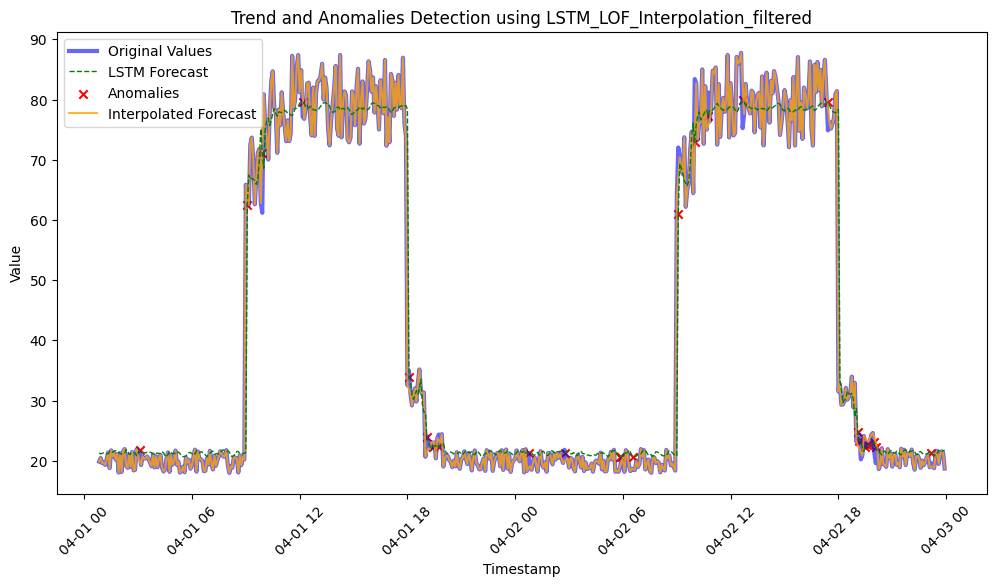

In [26]:
# Filter the dataset for the specific date range
start_date = "2014-04-01"
end_date = "2014-04-02"
df_filtered = df.loc[start_date:end_date]

# Plot only the filtered date range
plt.figure(figsize=(12, 6))
plt.plot(df_filtered.index, df_filtered["value"], label="Original Values", color="blue", alpha=0.6, linewidth= 3)
plt.plot(df_filtered.index, df_filtered["forecast"], label="LSTM Forecast", linestyle="dashed", color="green", alpha=1, zorder = 3, linewidth= 1.0)
plt.scatter(df_filtered.index[df_filtered["anomaly"]], df_filtered["forecast"][df_filtered["anomaly"]], 
            color="red", label="Anomalies", marker="x")
plt.plot(df_filtered.index, df_filtered["smoothed_value"], label="Interpolated Forecast", color="orange", linewidth=1.5, alpha = 0.8)
plt.title("Trend and Anomalies Detection using LSTM_LOF_Interpolation_filtered")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [24]:
# Statistics on Anomalies
original_anomalies_count = df["anomaly"].sum()
print(f"Original Anomalies Detected: {original_anomalies_count}")
original_variance = np.var(df["value"])
smoothed_variance = np.var(df["smoothed_value"])
print(f"Original Variance: {original_variance:.4f}")
print(f"Smoothed Variance: {smoothed_variance:.4f}")
print(f"Variance Reduction: {original_variance - smoothed_variance:.4f}")

Original Anomalies Detected: 202
Original Variance: 788.8906
Smoothed Variance: 787.5658
Variance Reduction: 1.3248
